In [19]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import random
from torch.utils.data import DataLoader

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)


Random Seed:  999


In [20]:
num_epochs = 20
batch_size = 32
log_interval = 10

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


In [23]:

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Function to split the dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)



# print the size of the datasets
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")


Train size: 50000
Validation size: 10000


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(mu.device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def representation(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.fc3(z)
        return self.decoder(z), mu, logvar

        

In [ ]:
# print the architecture of the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
print(model)


VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)


In [26]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [27]:


import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar):
    # normalize x to be between 0 and 1 and remove negative values
    x = F.relu(x)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD



In [28]:
from skimage.metrics import structural_similarity as ssim

# compute the mean squared error and the ssim score
def compute_mse(x, recon_x):
    x = F.relu(x)
    mse_loss = F.mse_loss(x, recon_x, reduction='sum')
    return mse_loss


def compute_ssim(x, recon_x):
    # Permute to (batch, height, width, channels) for SSIM
    x = x.permute(0, 2, 3, 1)  # Convert to (batch, height, width, channels)
    recon_x = recon_x.permute(0, 2, 3, 1)
    
    # Apply ReLU activation to ensure non-negative values
    x = F.relu(x)
    recon_x = F.relu(recon_x)

    # Calculate SSIM with a specified win_size
    ssim_loss = 1 - ssim(
        x.detach().cpu().numpy(),
        recon_x.detach().cpu().numpy(),
        data_range=1,
        multichannel=True,
        win_size=7,  
        channel_axis=-1  # Last dimension is channels
    )
    return ssim_loss


In [29]:
# from pathlib import Path

# OUT_DIR = Path("results")
# OUT_DIR.mkdir(parents=True, exist_ok=True)


In [30]:
def train(epoch):
    model.train()
    train_loss = 0.0
    mse_loss = 0.0
    ssim_loss = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        mse = compute_mse(data, recon_batch)
        ssim_val = compute_ssim(data, recon_batch)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        mse_loss += mse.item()
        ssim_loss += ssim_val

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    avg_loss = train_loss / len(train_loader.dataset)
    avg_mse = mse_loss / len(train_loader.dataset)
    avg_ssim = ssim_loss / len(train_loader.dataset)

    print(
        f'====> Epoch: {epoch} '
        f'Average loss: {avg_loss:.4f} '
        f'Average MSE: {avg_mse:.6f} '
        f'Average SSIM loss: {avg_ssim:.6f}'
    )

    return avg_loss, avg_mse, avg_ssim


In [31]:
def test(epoch):
    model.eval()
    test_loss = 0.0
    mse_loss = 0.0
    ssim_loss = 0.0

    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)

            test_loss += loss_function(recon_batch, data, logvar=logvar, mu=mu).item()
            mse = compute_mse(data, recon_batch)
            ssim_val = compute_ssim(data, recon_batch)

            mse_loss += mse.item()
            ssim_loss += ssim_val

            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([
                    data[:n],
                    recon_batch.view(batch_size, 3, 64, 64)[:n]
                ])
                save_image(comparison.cpu(),
                           'results/reconstruction_' + str(epoch) + '.png',
                           nrow=n)

    avg_test_loss = test_loss / len(val_loader.dataset)
    avg_test_mse = mse_loss / len(val_loader.dataset)
    avg_test_ssim = ssim_loss / len(val_loader.dataset)

    print(
        f'====> Test set loss: {avg_test_loss:.4f} '
        f'MSE: {avg_test_mse:.6f} '
        f'SSIM loss: {avg_test_ssim:.6f}'
    )

    return avg_test_loss, avg_test_mse, avg_test_ssim


In [32]:
import time

if __name__ == "__main__":
    train_losses = []
    test_losses = []

    # train / test MSE and SSIM
    mse_losses = []        # train MSE
    ssim_losses = []       # train SSIM (as you currently define it)
    test_mse_losses = []   # test MSE
    test_ssim_losses = []  # test SSIM

    epochs = []

    # time tracking
    epoch_times = []       # time per epoch (seconds)
    cumulative_times = []  # total training time elapsed (seconds)

    start_time = time.time()
    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()

        train_loss, train_mse, train_ssim = train(epoch)
        test_loss, test_mse, test_ssim = test(epoch)

        # log metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        mse_losses.append(train_mse)
        ssim_losses.append(train_ssim)
        test_mse_losses.append(test_mse)
        test_ssim_losses.append(test_ssim)
        epochs.append(epoch)

        # time for this epoch and cumulative time
        epoch_duration = time.time() - epoch_start
        epoch_times.append(epoch_duration)
        cumulative_times.append(time.time() - start_time)

        with torch.no_grad():
            sample = torch.randn(64, 1024, 1, 1).to(device)
            sample = model.decoder(sample).cpu()
            save_image(
                sample.view(64, 3, 64, 64),
                'results/sample_' + str(epoch) + '.png'
            )

    total_training_time = time.time() - start_time
    print(f"Total training time: {total_training_time:.2f}s")


Train Epoch: 1 [0/50000 (0%)]	Loss: 8551.444336
Train Epoch: 1 [320/50000 (1%)]	Loss: 6725.520020
Train Epoch: 1 [640/50000 (1%)]	Loss: 5811.349609
Train Epoch: 1 [960/50000 (2%)]	Loss: 5049.533691
Train Epoch: 1 [1280/50000 (3%)]	Loss: 4870.554688
Train Epoch: 1 [1600/50000 (3%)]	Loss: 4931.796387
Train Epoch: 1 [1920/50000 (4%)]	Loss: 5485.685059
Train Epoch: 1 [2240/50000 (4%)]	Loss: 4066.719971
Train Epoch: 1 [2560/50000 (5%)]	Loss: 4247.063477
Train Epoch: 1 [2880/50000 (6%)]	Loss: 4349.552734
Train Epoch: 1 [3200/50000 (6%)]	Loss: 4644.343262
Train Epoch: 1 [3520/50000 (7%)]	Loss: 3925.318359
Train Epoch: 1 [3840/50000 (8%)]	Loss: 4942.422852
Train Epoch: 1 [4160/50000 (8%)]	Loss: 4335.394043
Train Epoch: 1 [4480/50000 (9%)]	Loss: 4053.334229
Train Epoch: 1 [4800/50000 (10%)]	Loss: 4198.483887
Train Epoch: 1 [5120/50000 (10%)]	Loss: 3724.241455
Train Epoch: 1 [5440/50000 (11%)]	Loss: 4865.279297
Train Epoch: 1 [5760/50000 (12%)]	Loss: 3881.924072
Train Epoch: 1 [6080/50000 (12%)]

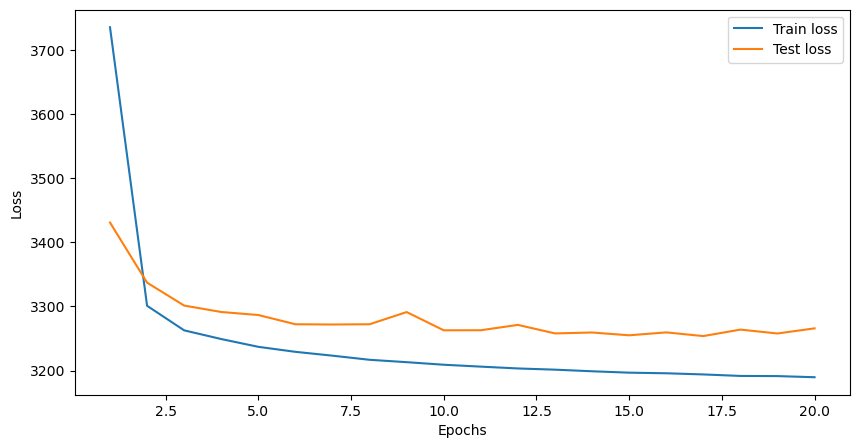

In [33]:
# plot the losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, test_losses, label="Test loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

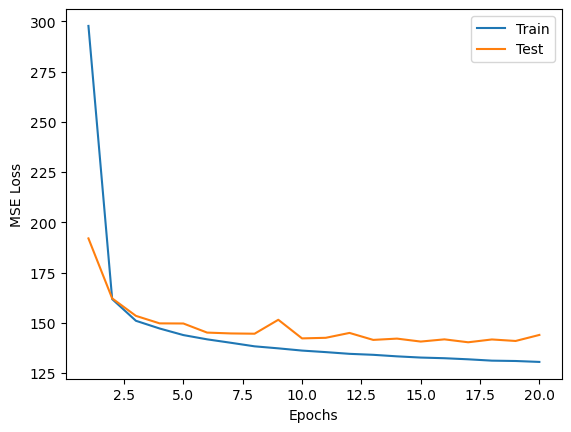

In [34]:
# plot the mse train and test loss over the epochs
import matplotlib.pyplot as plt
plt.plot(epochs, mse_losses, label='Train')
plt.plot(epochs, test_mse_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

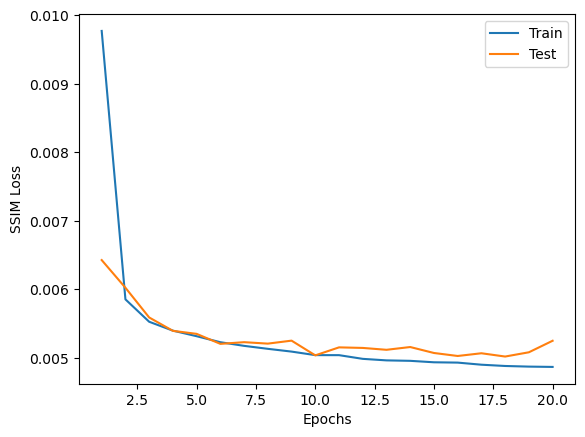

In [35]:
# plot the ssim train and test loss over the epochs
plt.plot(epochs, ssim_losses, label='Train')
plt.plot(epochs, test_ssim_losses, label='Test')
plt.xlabel('Epochs')
plt.ylabel('SSIM Loss')
plt.legend()
plt.show()


In [36]:
# save the model
torch.save(model.state_dict(), "modelVAE.pth")

### plots:
- Graph 1: train MSE vs time (seconds since start)

- Graph 2: train & test MSE vs time

- Graph 3: train & test VAE loss vs epochs

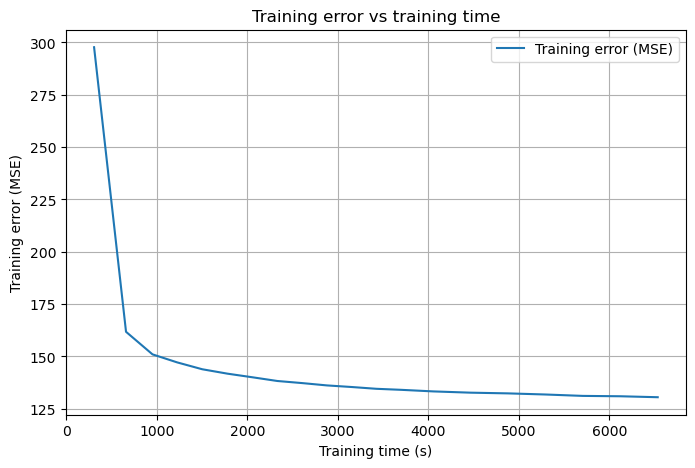

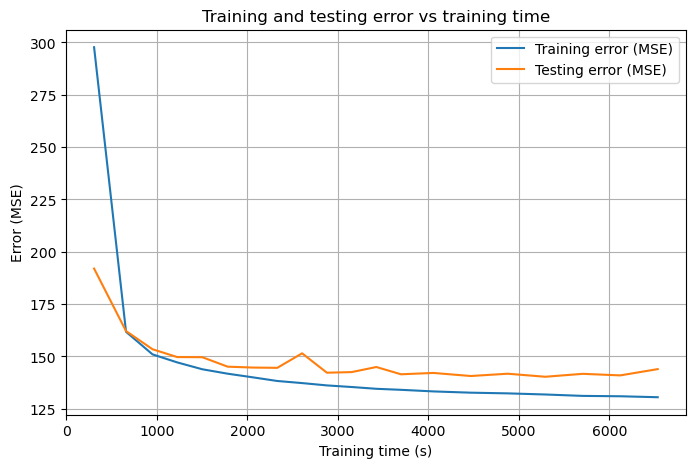

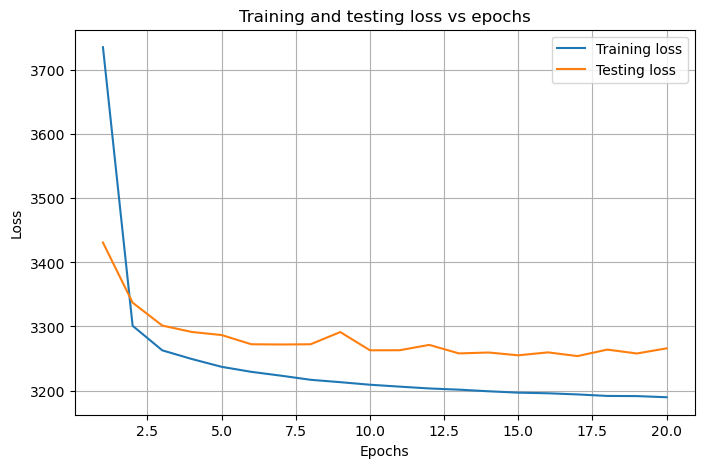

In [37]:
import matplotlib.pyplot as plt

# 1) Training error (MSE) vs training time
plt.figure(figsize=(8, 5))
plt.plot(cumulative_times, mse_losses, label='Training error (MSE)')
plt.xlabel('Training time (s)')
plt.ylabel('Training error (MSE)')
plt.title('Training error vs training time')
plt.legend()
plt.grid(True)
plt.show()

# 2) Training + testing error (MSE) vs training time
plt.figure(figsize=(8, 5))
plt.plot(cumulative_times, mse_losses, label='Training error (MSE)')
plt.plot(cumulative_times, test_mse_losses, label='Testing error (MSE)')
plt.xlabel('Training time (s)')
plt.ylabel('Error (MSE)')
plt.title('Training and testing error vs training time')
plt.legend()
plt.grid(True)
plt.show()

# 3) Training + testing loss vs epochs
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label='Training loss')
plt.plot(epochs, test_losses, label='Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and testing loss vs epochs')
plt.legend()
plt.grid(True)
plt.show()
